## LLM

In [1]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, TokenizerChar, word_split, normalize_to_ascii, pair_freq
from src.data_handling import read_first_n, normalize_to_ascii


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.data_handling import fused_qa
import sys
import random
import json

# disable gpu for testing purposes
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
def get_top_n_evidence(n, rank, evidence_article):
    top_n = []
    for i in range(n):
        article = evidence_article[rank[i][0]]
        top_n.append(article)
    return top_n

In [3]:
with open('corpus/triviaqa-rc/qa/wikipedia-train.json', 'r', encoding='utf-8') as f:
    squad = json.load(f)

question_wiki_list = []
answer_wiki_list = []
evidence_wiki_list = []

for qa in tqdm(squad['Data']):
    question_wiki_list.append(qa['Question'])
    answer_wiki_list.append(qa['Answer']["Value"])
    sr = qa["EntityPages"]
    if len(sr) > 0: 
        evidence_wiki_list.append(sr[0]["Filename"])
    else:
        evidence_wiki_list.append(None)
    

  0%|          | 0/61888 [00:00<?, ?it/s]

In [ ]:
path = "corpus/triviaqa-rc/evidence/wikipedia/"

evidence_article = {}
seen = {}

for i, evidence in tqdm(list(enumerate(evidence_wiki_list))):
    if evidence is not None:
        evidence = evidence.replace(":", "_").replace("?", "_").replace("*", "_").replace('"', "_")
        if not evidence in seen:
            seen[evidence] = 1
            try:
                txt = open(path + evidence, 'r', encoding='utf-8').read()
                evidence_article[evidence] = txt
            except:
                print("Error reading file: ", evidence)
                continue
        else:
            seen[evidence] += 1

  0%|          | 0/61888 [00:00<?, ?it/s]

In [ ]:
rank = [[evidence, freq] for freq, evidence in sorted(zip(seen.values(), seen.keys()), reverse=True)]

In [9]:
qa_wiki_grouped = [[] for _ in range(len(rank))]

for i, (evidence, freq) in tqdm(list(enumerate(rank))):
    for j, ref in enumerate(evidence_wiki_list):
        if evidence == ref:
            qa_wiki_grouped[i].append((question_wiki_list[j], answer_wiki_list[j]))
            

  0%|          | 0/28406 [00:00<?, ?it/s]

In [10]:
qa_wiki_flatten = []
for group in qa_wiki_grouped:
    for qa in group:
        qa_wiki_flatten.extend(qa)

In [ ]:
article_wiki_list = get_top_n_evidence(5000, rank, evidence_article)

text = "".join(article_wiki_list)
print("article_list: ", len(text))

article_list:  157051487


In [ ]:
len_list = [len(context) for context in article_wiki_list]
plt.hist(len_list, bins=100)

In [12]:
text = "".join(qa_wiki_flatten)
print("Length of question_web_list: ", len(text))

Length of question_web_list:  5566261


In [13]:
random.seed(42)

qa_wiki_clean_list = [normalize_to_ascii(x) for x in qa_wiki_flatten]
article_wiki_clean_list = [normalize_to_ascii(x) for x in article_wiki_list]

In [11]:
pkl.dump([qa_wiki_clean_list, article_wiki_clean_list], open("corpus/trivia_wiki_qa_article_clean", "wb"))

## Web

In [14]:
with open('corpus/triviaqa-rc/qa/web-train.json', 'r', encoding='utf-8') as f:
    squad = json.load(f)

question_web_list = []
answer_web_list = []
evidence_web_list = []

for qa in tqdm(squad['Data']):
    question_web_list.append(qa['Question'])
    answer_web_list.append(qa['Answer']["Value"])
    sr = qa['SearchResults']
    if len(sr) > 0: 
        evidence_web_list.append(sr[0]["Filename"])
    else:
        evidence_web_list.append(None)

  0%|          | 0/76496 [00:00<?, ?it/s]

In [15]:
path = "corpus/triviaqa-rc/evidence/web/"

evidence_article = {}
seen = {}

for i, evidence in tqdm(list(enumerate(evidence_web_list))):
    if evidence is not None:
        evidence = evidence.replace(":", "_").replace("?", "_").replace("*", "_").replace('"', "_")
        if not evidence in seen:
            seen[evidence] = 1
            try:
                txt = open(path + evidence, 'r', encoding='utf-8').read()
                evidence_article[evidence] = txt
            except:
                print("Error reading file: ", evidence)
                continue
        else:
            seen[evidence] += 1

  0%|          | 0/76496 [00:00<?, ?it/s]

In [16]:
rank = [[evidence, freq] for freq, evidence in sorted(zip(seen.values(), seen.keys()), reverse=True)]

qa_web_grouped = [[] for _ in range(len(rank))]

for i, (evidence, freq) in tqdm(list(enumerate(rank))):
    for j, ref in enumerate(evidence_web_list):
        if evidence == ref:
            qa_web_grouped[i].append((question_web_list[j], answer_web_list[j]))
            

  0%|          | 0/64719 [00:00<?, ?it/s]

In [17]:
article_web_list = get_top_n_evidence(5000, rank, evidence_article)

text = "".join(article_web_list)
print("article_list: ", len(text))

article_list:  71925754


In [18]:
qa_web_flatten = []
for group in qa_web_grouped:
    for qa in group:
        qa_web_flatten.extend(qa)

In [46]:
random.seed(42)

qa_web_clean_list = [normalize_to_ascii(x) for x in qa_web_flatten]
article_web_clean_list = [normalize_to_ascii(x) for x in article_web_list]

In [ ]:
pkl.dump([qa_web_clean_list, article_web_clean_list], open("corpus/trivia_web_qa_article_clean", "wb"))

## Tokenize

In [ ]:
corpus = qa_wiki_clean_list + article_wiki_clean_list + qa_web_clean_list + article_web_clean_list

#tokenizer = TokenizerChar(corpus)

tokenizer = TokenizerBPE(corpus, 16000, lowercase=True)
tokenizer.destroy_hash()

pkl.dump(tokenizer, open('tokenizers/trivia_16k_full.pkl', 'wb'))

Lowercasing corpus


  0%|          | 0/126776 [00:00<?, ?it/s]

Merging tokens


  0%|          | 0/16000 [00:00<?, ?it/s]

t h 2283821
i n 1808021
th e 1650954
a n 1517695
e r 1361619
o n 1221025
r e 1040645
a t 901993
e n 873632
e d 868777
o r 831623
a l 827763
s t 822449
a r 781239
o f 711807
an d 687112
i s 637624
a s 629339
e s 612191
i t 578174
i c 560089
in g 524059
t o 509951
r o 479139
i on 443019
l e 416757
o u 408293
c h 354605
en t 318918
i l 308665
s e 300449
a m 297264
e l 274825
c o 265617
a d 262858
w h 254693
a c 251229
b e 241116
f or 234044
l y 231240
d e 219450
u r 211655
u n 209864
o l 202883
i m 199800
i v 190917
i r 190665
w as 187359
i g 182565
at ion 179449
t er 173297
u s 172534
o w 172530
c on 170730
c e 168126
w i 161263
v er 156052
1 9 155803
b y 154206
a y 152396
i d 151675
m o 150050
a g 148737
c t 147787
h e 146947
s u 146654
m e 144022
' s 143450
wi th 142201
p e 142020
u l 131029
a re 130757
t e 130173
s o 130137
i st 129001
t r 127470
a p 127434
n e 124835
er s 122352
p o 120719
a v 120707
a b 120156
th at 119805
co m 118447
p l 115997
p ro 115509
al l 114412
re s 113258
a

## Fuse

In [23]:
def fused_qa(qa_grouped):
    q ="<q>"
    a = "<a>"
    sos = "<s>"
    eos = "</s>"

    corpus_list = []
    for group in qa_grouped: 
        for qa in group:
            corpus_list.append(sos)
            question = normalize_to_ascii(qa[0]).lower()
            answer = normalize_to_ascii(qa[1]).lower()
            corpus_list.extend([q, question, a, answer])
            corpus_list.append(eos)
        
    return "".join(corpus_list)


def fused_article(corpus_list):
    sos = "<s>"
    eos = "</s>"

    corpus_padded_list = []
    for line in corpus_list:
        line = [sos, line.lower(), eos]
        corpus_padded_list.extend(line)
    
    return "".join(corpus_padded_list)

In [24]:
tokenizer = pkl.load(open('tokenizers/trivia_24k_full.pkl', 'rb'))
tokenizer.create_hash()

tokenizer.add_special_tokens(["<s>", "</s>", "<q>", "<a>",])

In [25]:
corpus_wiki_qa_fused = fused_qa(qa_wiki_grouped)

corpus_wiki_qa_encoded = tokenizer.encode(corpus_wiki_qa_fused)

pkl.dump(corpus_wiki_qa_encoded, open('corpus/trivia_qa_wiki_grouped_24k_encoded', 'wb'))

  0%|          | 0/24000 [00:00<?, ?it/s]

In [26]:
corpus_wiki_article_fused = fused_article(article_wiki_clean_list)

corpus_article_encoded = tokenizer.encode(corpus_wiki_article_fused)

pkl.dump(corpus_article_encoded, open('corpus/trivia_wiki_article_24k_encoded', 'wb'))

  0%|          | 0/24000 [00:00<?, ?it/s]

In [29]:
corpus_wiki_qa_encoded.shape

TensorShape([1, 2298337])

In [28]:
corpus_article_encoded.shape

TensorShape([1, 58802975])

In [30]:
corpus_web_qa_fused = fused_qa(qa_web_grouped)
corpus_web_qa_encoded = tokenizer.encode(corpus_web_qa_fused)
pkl.dump(corpus_web_qa_encoded, open('corpus/trivia_qa_web_grouped_24k_encoded', 'wb'))

  0%|          | 0/24000 [00:00<?, ?it/s]

In [47]:
corpus_web_article_fused = fused_article(article_web_clean_list)
corpus_web_article_encoded = tokenizer.encode(corpus_web_article_fused)
pkl.dump(corpus_web_article_encoded, open('corpus/trivia_web_article_24k_encoded', 'wb'))

  0%|          | 0/24000 [00:00<?, ?it/s]

In [ ]:
corpus_web_article_encoded.shape

TensorShape([1, 58802975])

In [48]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, fuse_tokenized_corpus, chunk_corpus
from sklearn.model_selection import train_test_split


import os
import time
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import *
from src.data_handling import read_first_n, sample_batch



print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [49]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [50]:
def chunk_and_batch(corpus, chunk_size, train_batch_size, test_batch_size, repeat=True, ratio=0.8):
    base = (tf.data.Dataset
            .from_tensor_slices(corpus)
            .batch(chunk_size, drop_remainder=True)
            # shuffle exactly once, freeze this order forever
            .shuffle(buffer_size=10000,
                     seed=42,
                     reshuffle_each_iteration=False))

    # 2) carve out train/test (fixed split)
    num_segments = base.cardinality().numpy()
    num_train    = int(ratio * num_segments)
    ds_train   = base.take(num_train)
    ds_test    = base.skip(num_train)

    # 3) build train pipeline: repeat → shuffle → batch → prefetch

    if repeat:
        ds_train = ds_train.repeat()
        ds_test  = ds_test.repeat()  

    ds_train = (ds_train                       
                .shuffle(buffer_size=10000, seed=42, reshuffle_each_iteration=False)  # new random order each epoch
                .batch(train_batch_size)
                .prefetch(tf.data.AUTOTUNE))

    # 4) build test pipeline: just repeat & batch   
    ds_test = (ds_test
               .shuffle(buffer_size=10000, seed=42, reshuffle_each_iteration=False)
               .batch(test_batch_size)
               .prefetch(tf.data.AUTOTUNE))

    return ds_train, ds_test

In [51]:
max_seq_len = 512

tokenizer = pkl.load(open('tokenizers/trivia_24k_full.pkl', 'rb'))
tokenizer.create_hash()

tokenizer.add_special_tokens(["<s>", "</s>", "<q>", "<a>",])

In [52]:
corpus_qa_wiki_encoded = pkl.load(open('corpus/trivia_qa_wiki_grouped_24k_encoded', 'rb'))
corpus_article_wiki_encoded = pkl.load(open('corpus/trivia_wiki_article_24k_encoded', 'rb'))

corpus_qa_web_encoded = pkl.load(open('corpus/trivia_qa_web_grouped_24k_encoded', 'rb'))
corpus_article_web_encoded = pkl.load(open('corpus/trivia_web_article_24k_encoded', 'rb'))

corpus = tf.concat([corpus_qa_wiki_encoded, corpus_article_wiki_encoded, corpus_qa_web_encoded, corpus_article_web_encoded], axis=1)[0]

ds_train, ds_test = chunk_and_batch(corpus, chunk_size=max_seq_len, train_batch_size=24, test_batch_size=4, repeat=True)


In [53]:
initial_lr = 1e-4
decay_steps = 25000
decay_rate = 0.5
decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

warmup_steps = 1000
lr_schedule = WarmUpThenDecay(
    initial_learning_rate=initial_lr,
    warmup_steps=warmup_steps,
    decay_schedule_fn=decay_schedule)

np.random.seed(42)
tf.random.set_seed(42)

max_seq_len = 512
embed_dim = 640
tf_blocks = 10
heads = 10
ff_dim = 4*embed_dim
weight_decay = 0.01
dropout = 0.1

unembed_dims = []

model = Transformer(vocab_size=tokenizer.vocab_size,
                    max_seq_len=max_seq_len,
                    embed_dim=embed_dim,
                    tf_blocks=tf_blocks,
                    heads=heads,
                    ff_dim = ff_dim,
                    unembed_dims=unembed_dims,
                    tokenizer=tokenizer,
                    lr=lr_schedule,
                    wd = weight_decay,
                    dropout=dropout,
                    )

losses_train = []
losses_test = []


In [54]:
name = "model_24k_Trivia_full"


ckpt = tf.train.Checkpoint(
    optimizer=model.opt,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/" + name,      # folder where ckpts are saved
    max_to_keep=5                         # only keep 5 latest checkpoints
)

In [ ]:
ckpt.restore(ckpt_manager.latest_checkpoint)
losses_train, losses_test = pkl.load(open("checkpoints/losses_" + name + ".pkl", 'rb'))

In [55]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")

Total number of parameters: 64984739


In [56]:
def train_loop(iter_train, iter_test):
    for i, (batch_train, batch_test) in tqdm(enumerate(zip(iter_train, iter_test))):
        loss_train = model.train_step(batch_train).numpy()
        losses_train.append(loss_train)
        
        loss_test = model.evaluate(batch_test).numpy()
        losses_test.append(loss_test)

        if (i+1) % 1000 == 0:
            ckpt_manager.save()
            pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))

        lr = model.opt.inner_optimizer._decayed_lr(tf.float32).numpy()
        print(loss_train, loss_test, lr)
    return losses_train, losses_test

In [57]:
iter_train = ds_train.take(1000000)
iter_test = ds_test.take(1000000)

In [58]:
train_loop(iter_train, iter_test)

0it [00:00, ?it/s]

🔄 Tracing train_step; token shape: (None, None)
🔄 Tracing train_step; token shape: (None, None)
14.889557 14.973317 1e-07
14.694532 14.894465 2e-07
14.741839 14.708427 2.9999998e-07
14.651205 14.481497 4e-07
14.628636 14.755308 5e-07
14.488562 14.424189 5.9999996e-07
14.392818 14.47255 7e-07
14.128203 14.581427 8e-07
13.94458 13.304508 8.999999e-07
13.718731 13.044102 1e-06
13.568531 13.102719 1.1e-06
13.410627 12.265889 1.1999999e-06
12.8514385 12.000847 1.3e-06
12.431433 11.792759 1.4e-06
12.330667 10.449826 1.4999999e-06
11.778526 10.399018 1.6e-06
11.458532 9.59992 1.7000001e-06
10.878466 9.027085 1.7999998e-06
10.595259 8.351527 1.8999999e-06
9.966996 8.527522 2e-06
9.6451 8.430303 2.0999998e-06
9.286898 8.888515 2.2e-06
8.414773 8.570922 2.3e-06
9.03759 9.252334 2.3999999e-06
9.045798 9.641103 2.5e-06
9.111718 9.869915 2.6e-06
9.285755 10.066004 2.7e-06
9.747087 9.602199 2.8e-06
9.141577 10.038259 2.8999998e-06
9.294464 9.869012 2.9999999e-06
8.958743 8.985553 3.1e-06
8.748596 8.

KeyboardInterrupt: 

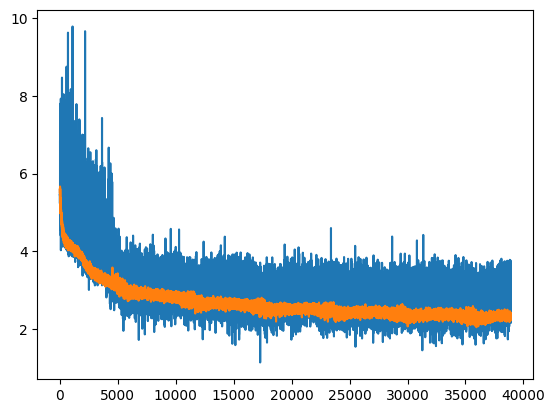

In [59]:
plt.plot(losses_test[100:], label="Test Loss")
plt.plot(losses_train[100:], label="Train Loss")

In [122]:
system_promt = ""
text = "Where is putin from?"
text = text.lower()
SOS = tf.convert_to_tensor([[tokenizer.token_to_idx["<s>"]]])
Q = tf.convert_to_tensor([[tokenizer.token_to_idx["<q>"]]])
A = tf.convert_to_tensor([[tokenizer.token_to_idx["<a>"]]])
sp_indices = tf.cast(tokenizer.encode(system_promt.lower()), tf.int32)
indices = tf.cast(tokenizer.encode(text), tf.int32)
#indices = tf.concat([SOS, Q, indices, A], axis=1)
#indices = tf.concat([SOS, indices], axis=1)
indices = tf.concat([SOS, sp_indices, Q, indices, A], axis=1)
print(indices)

import textwrap
import ipywidgets as widgets
from IPython.display import display

T = 0.5
#tf.random.set_seed(42)
wrapper = textwrap.TextWrapper(width=80)

# create a read-only text area
ta = widgets.Textarea(
    value="",
    layout=widgets.Layout(width='80ch', height='20em'),
    disabled=True
)
display(ta)

for i in range(512):
    logits = model.call(indices)[0, -1:]
    idx = tf.cast(
        tf.random.categorical(logits / T, num_samples=1),
        tf.int32
    )
    indices = tf.concat([indices, idx], axis=1)

    text_pred = (
        tokenizer
        .decode(indices)
        .numpy()[0]
        .decode('utf-8')
        .replace("\n", " ")
    )
    ta.value = wrapper.fill(text_pred)  # this updates in-place

    if idx[0, 0] == tokenizer.token_to_idx["</s>"] or idx[0, 0] == tokenizer.token_to_idx["<q>"]:
        break

  0%|          | 0/24000 [00:00<?, ?it/s]

  0%|          | 0/24000 [00:00<?, ?it/s]

tf.Tensor([[24095 24097   522    25   111    25  9266    25   197    56 24098]], shape=(1, 11), dtype=int32)


Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

## 